## Data Preparation 

Need to download data for Fiji, Cook Ilsand, Marshall Island and Palaos to train a random forest that return land cover classification over the pacific region. 

Input Data : 
- lat, lon
- Fractional Cover
- NDVI (optional or later)
- Label (class-id : 1. Forest ; 2. Cropland ; 3. Grassland ; 4. Buildup ; 5. Baresoil ; 6. Water ; 7. Mangroves)

The data are in the folder data, there 4 files (one per island), the goal is to create from these file the input dataset pour the Random Forest Classifier, by balancing the number of data per class and per region. 

In [1]:
import pandas as pd
import numpy as np 
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [32]:
# dataset path + loading

fiji_path = "./data/fiji.xlsx"
marshall_path = "./data/marshall.xlsx"
cook_path = "./data/cook.xlsx"
palaos_path = "./data/palaos.xlsx"

fj = pd.read_excel(fiji_path)
mh =  pd.read_excel(marshall_path)
ck =  pd.read_excel(cook_path)
pl =  pd.read_excel(palaos_path)

fj.head()

,fid,class_id,lulc,bs_pc_50,npv_pc_50,pv_pc_50,lon,lat
0,1,1,forest,9,0,87,178.325,-17.535
1,2,1,forest,5,8,94,178.300,-17.535
2,3,2,cropland,7,20,76,177.511,-17.551
3,4,1,forest,2,10,89,177.651,-17.550
4,5,2,cropland,8,31,60,177.664,-17.550


In [4]:
# Create a table summarizing the lulc category distribution 

def count_lulc(df, island_name):
    counts = df["lulc"].value_counts().to_frame(name=island_name).T
    return counts

fj_counts = count_lulc(fj, "Fiji")
mh_counts = count_lulc(mh, "Marshall")
ck_counts = count_lulc(ck, "Cook")
pl_counts = count_lulc(pl, "Palaos")

summary = pd.concat([fj_counts, mh_counts, ck_counts, pl_counts], axis=0).fillna(0).astype(int)
summary["Total"] = summary.sum(axis=1)
summary = summary.sort_values(by="Total", ascending=False)

summary.head()

lulc,forest,grassland,mangroves,cropland,buildup,water,baresoil,Total
Fiji,3267,1520,683,558,137,39,15,6219
Cook,103,59,0,80,113,55,181,591
Palaos,72,77,18,63,42,36,183,491
Marshall,142,22,6,4,47,25,55,301


To build a good classifier that generalizes well across the Pacific, balancing data is important :

- Balancing between classes (so each LULC type is equally learned)
- Balancing between locations (so it doesn't overfit to any specific island)

But a minimum amount of data is needed in order to have a good classifier. Regarging the previous table, the less represented classes are water (155) and buildup (339). Based on this, the objective is to keep aroun 150-300 points per lulc. Finally to preserve spatial generalization, points from each island should be equally reprensented in each class.

I set manually : 

- Forest : Fiji : 80 ; Cook : 75 ; Palaos : 70 ; Marshall : 75 = 300
- Grassland : Fiji : 150 ; Cook : 59 ; Palaos : 77 ; Marshall : 22 = 308
- Mangroves : Fiji : 180 ; Cook : 0 ; Palaos : 18 ; Marshall : 6 = 204
- Cropland : Fiji : 150 ; Cook : 80 ; Palaos : 63 ; Marshall : 4 = 300
- Buildup : Fiji : 110 ; Cook : 110 ; Palaos : 40 ; Marshall : 40 = 300
- Water : Fiji : 39 ; Cook : 55 ; Palaos : 36 ; Marshall : 25 = 155
- Baresoil : Fiji : 15 ; Cook : 115 ; Palaos : 115 ; Marshall : 55 = 300

Following this distribution, the RF would be trained on 1867 data points.

In [12]:
random.seed(42)

sampling_plan = {
    "forest":     {"Fiji": 80,  "Cook": 75,  "Palaos": 70,  "Marshall": 75},
    "grassland":  {"Fiji": 150, "Cook": 59,  "Palaos": 77,  "Marshall": 22},
    "mangroves":  {"Fiji": 180, "Cook": 0,   "Palaos": 18,  "Marshall": 6},
    "cropland":   {"Fiji": 150, "Cook": 80,  "Palaos": 63,  "Marshall": 4},
    "buildup":    {"Fiji": 110, "Cook": 110, "Palaos": 40,  "Marshall": 40},
    "water":      {"Fiji": 39,  "Cook": 55,  "Palaos": 36,  "Marshall": 25},
    "baresoil":   {"Fiji": 15,  "Cook": 115, "Palaos": 115, "Marshall": 55}
}

island_dfs = {
    "Fiji": fj,
    "Cook": ck,
    "Palaos": pl,
    "Marshall": mh
}


samples = []


for lulc_class, island_counts in sampling_plan.items():
    for island, n_points in island_counts.items():
        if n_points == 0:
            continue
        df = island_dfs[island]
        df_filtered = df[df["lulc"] == lulc_class]

        if len(df_filtered) < n_points:
            raise ValueError(f"Not enough data for {lulc_class} in {island} (needed {n_points}, available {len(df_filtered)})")

        # Convert to list of rows (dicts), sample with random
        filtered_list = df_filtered.to_dict(orient="records")
        selected = random.sample(filtered_list, n_points)

        # Reconvert to DataFrame and add island info
        selected_df = pd.DataFrame(selected)
        selected_df["island"] = island
        samples.append(selected_df)

# Concatenate all sampled rows
train_df = pd.concat(samples, ignore_index=True)

# Check result
print("Final shape:", train_df.shape)
print("Class counts:\n", train_df["lulc"].value_counts())
print("Island counts:\n", train_df["island"].value_counts())


Final shape: (1864, 9)
Class counts:
 lulc
grassland    308
forest       300
buildup      300
baresoil     300
cropland     297
mangroves    204
water        155
Name: count, dtype: int64
Island counts:
 island
Fiji        724
Cook        494
Palaos      419
Marshall    227
Name: count, dtype: int64


In [13]:
train_df = train_df.drop(columns=['fid'])
df = train_df.sample(frac=1).reset_index(drop=True)
df.head()

,class_id,lulc,bs_pc_50,npv_pc_50,pv_pc_50,lon,lat,island
0,4,buildup,18,15,63,-159.728423,-21.246324,Cook
1,5,baresoil,26,68,24,134.520000,7.416000,Palaos
2,5,baresoil,8,13,75,-159.794484,-21.259927,Cook
3,5,baresoil,3,20,75,134.513000,7.418000,Palaos
4,1,forest,9,13,84,-159.787544,-21.258889,Cook


In [14]:
df.to_excel('./data/training_data.xlsx')

In [15]:
import geopandas as gpd
from shapely.geometry import Point

# Create geometry column from lon/lat
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]

# Convert to GeoDataFrame with CRS 4326 (WGS 84)
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Save to shapefile
gdf.to_file("./data/training_data.shp", driver="ESRI Shapefile")

## Training 

In [24]:
# Select Features and Labels 
features = df[['bs_pc_50', 'npv_pc_50', 'pv_pc_50', 'lat', 'lon']]
labels = df['class_id']

# Train/Test Split 
X_train, X_val, y_train, y_val = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Train Random Forest Classifier 
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

# Make Predictions 
y_pred = rf.predict(X_val)

# Performance  Metrics
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')
kappa = cohen_kappa_score(y_val, y_pred)
report = classification_report(y_val, y_pred)


# Results 
print("Random Forest Classifier Performance")
print(f"Accuracy: {accuracy:.2%}")
print(f"Weighted F1-score: {f1:.2%}")
print(f"Cohen's Kappa: {kappa:.3f}")
print("\nClassification Report:\n", report)


Random Forest Classifier Performance
Accuracy: 75.07%
Weighted F1-score: 75.13%
Cohen's Kappa: 0.707

Classification Report:
               precision    recall  f1-score   support

           1       0.79      0.80      0.79        60
           2       0.75      0.68      0.71        59
           3       0.62      0.69      0.66        62
           4       0.75      0.77      0.76        60
           5       0.78      0.75      0.76        60
           6       0.84      0.84      0.84        31
           7       0.80      0.78      0.79        41

    accuracy                           0.75       373
   macro avg       0.76      0.76      0.76       373
weighted avg       0.75      0.75      0.75       373



In [25]:
# Get Feature Importances
importances = rf.feature_importances_
feature_names = features.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print Table
print("\nFeature Importances:")
print(importance_df)


Feature Importances:
     Feature  Importance
4        lon    0.276365
3        lat    0.260777
2   pv_pc_50    0.213197
1  npv_pc_50    0.128646
0   bs_pc_50    0.121014


## Testing 

In [36]:
test_path = './data/fiji_test.csv'
fiji_test = pd.read_csv(test_path)
fiji_test.head()

,fid,class_id,lulc,lon,lat,bs_pc_50,npv_pc_50,pv_pc_50
0,4875,3,grassland,179.956163,-16.164021,0,8,93
1,4879,3,grassland,179.931120,-16.176558,4,14,81
2,4880,1,forest,179.943732,-16.176384,5,10,93
3,4881,1,forest,179.956344,-16.176209,3,7,92
4,4884,2,cropland,179.880846,-16.189437,5,25,67


In [37]:
X_test = fiji_test[['bs_pc_50', 'npv_pc_50', 'pv_pc_50', 'lat', 'lon']]

# Predict classes with trained model
fiji_test['predicted_class'] = rf.predict(X_test)
fiji_test.head()

,fid,class_id,lulc,lon,lat,bs_pc_50,npv_pc_50,pv_pc_50,predicted_class
0,4875,3,grassland,179.956163,-16.164021,0,8,93,7
1,4879,3,grassland,179.931120,-16.176558,4,14,81,2
2,4880,1,forest,179.943732,-16.176384,5,10,93,7
3,4881,1,forest,179.956344,-16.176209,3,7,92,7
4,4884,2,cropland,179.880846,-16.189437,5,25,67,4


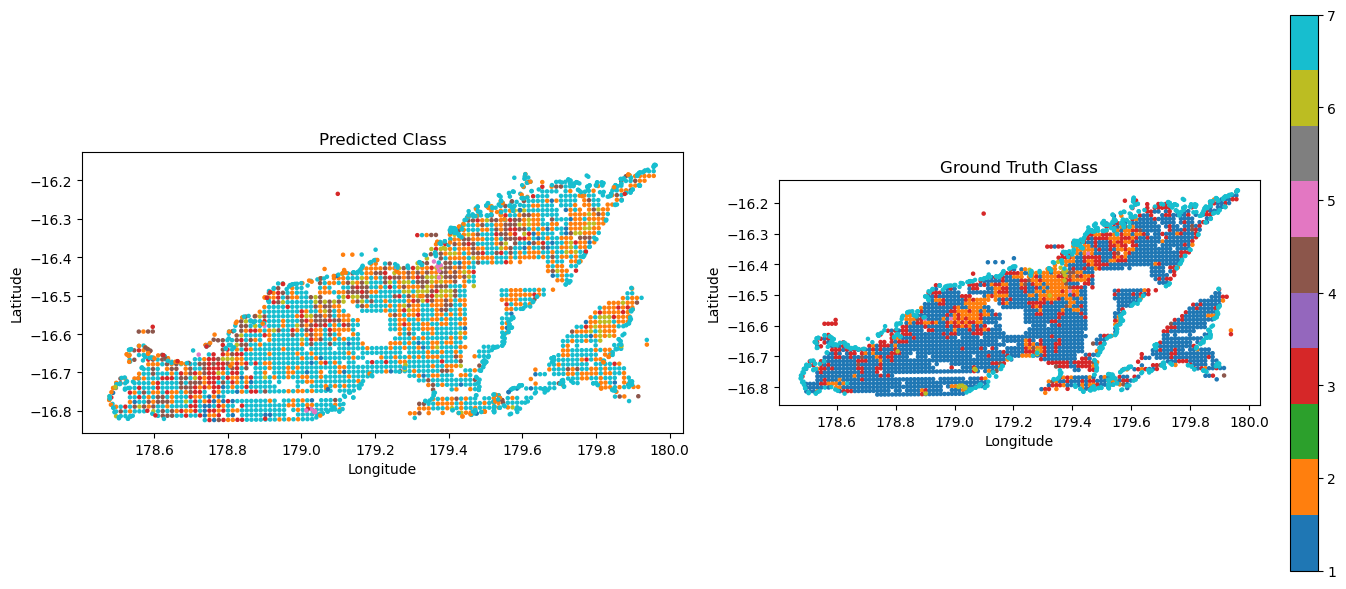

In [41]:
# Plot prediction and groundtruth 
geometry = [Point(xy) for xy in zip(fiji_test['lon'], fiji_test['lat'])]
gdf = gpd.GeoDataFrame(fiji_test, geometry=geometry, crs='EPSG:4326')


fig, axes = plt.subplots(1, 2, figsize=(14, 6))


gdf.plot(column='predicted_class', cmap='tab10', legend=False,
         ax=axes[0], markersize=5)
axes[0].set_title("Predicted Class")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
gdf.plot(column='class_id', cmap='tab10', legend=True,
         ax=axes[1], markersize=5)
axes[1].set_title("Ground Truth Class")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

plt.tight_layout()
plt.show()
